# Toy Correlation Tutorial

In this notebook we explore how different correlation assumptions impact a simple two-measurement combination. Both measurements provide an estimate of the same quantity with central values +1 and -1. Their statistical uncertainties are $\sqrt{2}$ and we introduce a single systematic source also of magnitude $\sqrt{2}$. All error-on-error terms ($\epsilon$) are set to zero so only the correlations influence the result.

For systematic uncertainties without an associated error-on-the-error, the log-likelihood is constructed using the BLUE approach, as described in Sec. 2 of [arXiv:2407.05322](https://arxiv.org/abs/2407.05322). 


In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

script_dir = os.getcwd()
gvm_root = os.path.abspath(os.path.join(script_dir, "../../"))
if gvm_root not in sys.path:
    sys.path.insert(0, gvm_root)

from gvm_toolkit import GVMCombination

The following cells build a `GVMCombination` for each correlation scenario. After running the fit we print the estimated mean (`mu_hat`), the 68% confidence interval and the goodness-of-fit (chi-square) value.


## 1. Decorrelated case
Here the systematic uncertainty is defined as independent for each measurement (no correlation matrix).

In [2]:
comb = GVMCombination('correlations/decorrelated.yaml')
mu_hat = comb.fit_results['mu']
ci_low, ci_high, _ = comb.confidence_interval()
chi2 = comb.goodness_of_fit()
print(f'decorrelated: mu_hat={mu_hat:.4f}, CI=({ci_low:.4f}, {ci_high:.4f}), chi2={chi2:.3f}')


decorrelated: mu_hat=0.0000, CI=(-1.4188, 1.4138), chi2=0.500


## 2. Correlation examples
We now compare three different correlation matrices for the systematic uncertainty:
1. **Diagonal**: off-diagonal terms are zero so the systematic acts independently.
2. **Fully correlated**: all coefficients are one so the systematic behaves as one shared nuisance parameter.
3. **Hybrid**: the off-diagonal coefficient is 0.5 representing a partial correlation.


In [3]:
comb = GVMCombination('correlations/diag_corr.yaml')
mu_hat = comb.fit_results['mu']
ci_low, ci_high, _ = comb.confidence_interval()
chi2 = comb.goodness_of_fit()
print(f'diag_corr: mu_hat={mu_hat:.4f}, CI=({ci_low:.4f}, {ci_high:.4f}), chi2={chi2:.3f}')

comb = GVMCombination('correlations/full_corr.yaml')
mu_hat = comb.fit_results['mu']
ci_low, ci_high, _ = comb.confidence_interval()
chi2 = comb.goodness_of_fit()
print(f'full_corr: mu_hat={mu_hat:.4f}, CI=({ci_low:.4f}, {ci_high:.4f}), chi2={chi2:.3f}')

comb = GVMCombination('correlations/hybrid_corr.yaml')
mu_hat = comb.fit_results['mu']
ci_low, ci_high, _ = comb.confidence_interval()
chi2 = comb.goodness_of_fit()
print(f'hybrid_corr: mu_hat={mu_hat:.4f}, CI=({ci_low:.4f}, {ci_high:.4f}), chi2={chi2:.3f}')


diag_corr: mu_hat=0.0000, CI=(-1.4188, 1.4138), chi2=0.500
full_corr: mu_hat=0.0000, CI=(-1.7375, 1.7325), chi2=1.000
hybrid_corr: mu_hat=0.0000, CI=(-1.5888, 1.5813), chi2=0.667


## 3. Non-diagonal statistical covariance
The same systematic is fully correlated as above, but this time the statistical uncertainties are specified via a covariance matrix that includes non-zero off-diagonal terms.

Unlike systematic uncertainties — which can be described through correlation matrices — statistical uncertainties must be provided directly as a **covariance matrix**. This means that if the statistical uncertainties are $\sqrt{2}$ for both measurements, and a correlation coefficient of $0.5$ is used, then the corresponding covariance matrix is:

2 1<br>1 2

In [15]:
comb = GVMCombination('correlations/stat_cov.yaml')
mu_hat = comb.fit_results['mu']
ci_low, ci_high, _ = comb.confidence_interval()
chi2 = comb.goodness_of_fit()
print(f'stat_cov: mu_hat={mu_hat:.4f}, CI=({ci_low:.4f}, {ci_high:.4f}), chi2={chi2:.3f}')


stat_cov: mu_hat=0.0000, CI=(-1.8788, 1.8713), chi2=2.000


## Tip: modifying the combination
You can obtain the current input with `input_data()` and modify the returned dictionary. 
After editing, pass it to `update_data()` to apply the changes before refitting.


In [16]:
comb = GVMCombination('correlations/decorrelated.yaml')

# extract current configuration
info = comb.input_data()

# change measurement and systematic values
info['data']['measurements']['m1']['central'] = 2.0
info['syst']['sys1']['values']['m1'] = 0.5

# update the systematic to be dependent with a new correlation matrix
info['syst']['sys1']['type'] = 'dependent'
info['syst']['sys1']['corr'] = np.array([[1.0, 0.3], [0.3, 1.0]])

# apply modifications and refit
comb.update_data(info)
comb.fit_results = comb.minimize()
print(f"updated mu_hat={comb.fit_results['mu']:.4f}")


updated mu_hat=0.9506


## 4. Effect of error-on-error
We now vary the error-on-error parameter ($\epsilon$) from 0 to 0.6 while also changing the measurement central values to $\pm1$, $\pm2$ and $\pm3$. This shows how the compatibility of the inputs modifies the combination results. Each scenario below produces three plots for the central value, the confidence interval half-size and the goodness-of-fit.

### Decorrelated


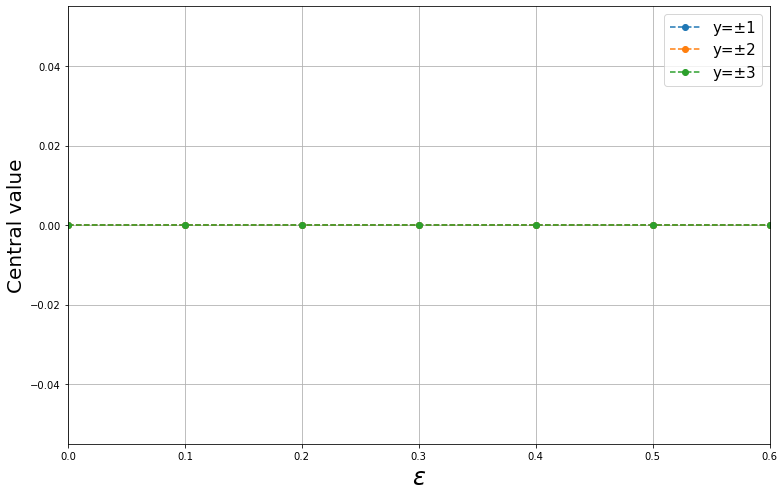

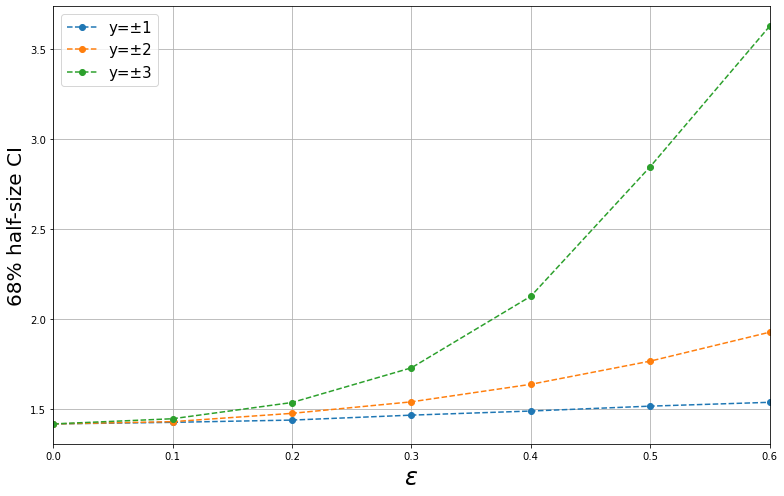

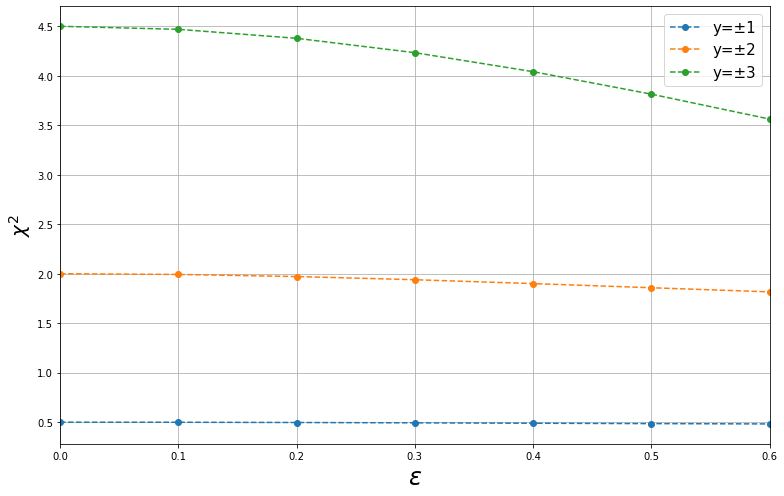

In [17]:
eps_grid = np.linspace(0., 0.6, 7)
y_vals = [1, 2, 3]
comb = GVMCombination('correlations/decorrelated.yaml')
base_info = comb.input_data()
cv = {y: [] for y in y_vals}
ci = {y: [] for y in y_vals}
gof = {y: [] for y in y_vals}
for y in y_vals:
    for eps in eps_grid:
        info = deepcopy(base_info)
        info['data']['measurements']['m1']['central'] = float(y)
        info['data']['measurements']['m2']['central'] = -float(y)
        info['syst']['sys1']['epsilon'] = float(eps)
        comb.update_data(info)
        cv[y].append(comb.fit_results['mu'])
        ci[y].append(comb.confidence_interval()[2])
        gof[y].append(comb.goodness_of_fit())

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, cv[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel('Central value', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/decorrelated_cv.png')
plt.show()

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, ci[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel('68% half-size CI', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/decorrelated_ci.png')
plt.show()

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, gof[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel(r'$\chi^2$', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/decorrelated_gof.png')
plt.show()


Three effects can be observed:

1. The **central values remain constant**: the combination is symmetric, as the two measurements have identical statistical and systematic uncertainties.

2. The **confidence interval widens** as $\varepsilon$ increases. Moreover, the more mutually incompatible the measurements are, the more pronounced this effect becomes.

3. The **goodness-of-fit decreases** with increasing $\varepsilon$. Again, this degradation is more significant when the measurements are mutually inconsistent.

### Diagonal correlation


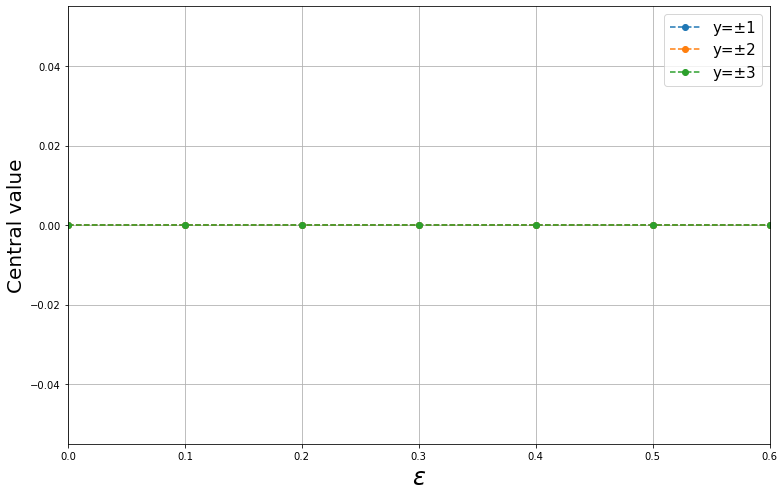

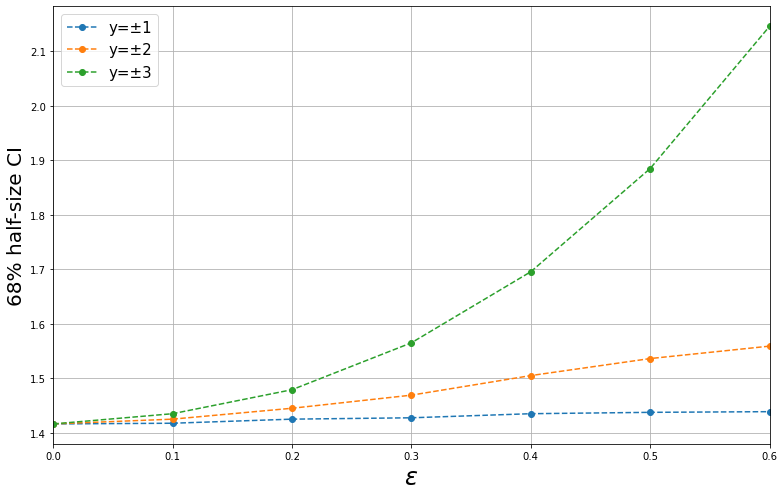

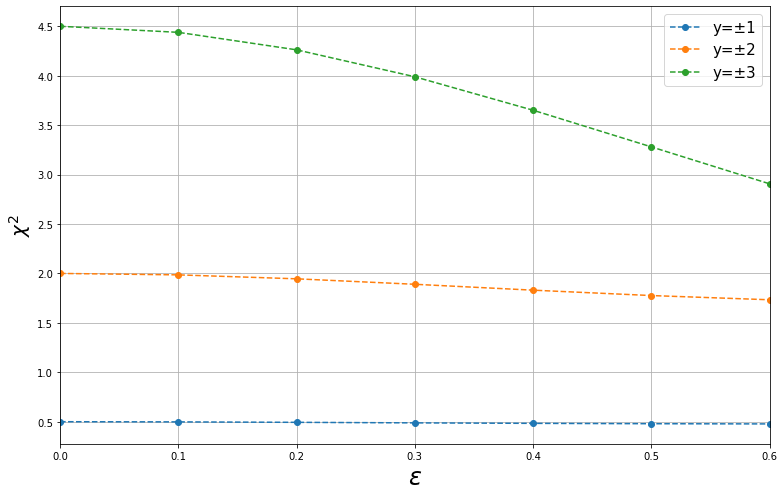

In [18]:
eps_grid = np.linspace(0., 0.6, 7)
y_vals = [1, 2, 3]
comb = GVMCombination('correlations/diag_corr.yaml')
base_info = comb.input_data()
cv = {y: [] for y in y_vals}
ci = {y: [] for y in y_vals}
gof = {y: [] for y in y_vals}
for y in y_vals:
    for eps in eps_grid:
        info = deepcopy(base_info)
        info['data']['measurements']['m1']['central'] = float(y)
        info['data']['measurements']['m2']['central'] = -float(y)
        info['syst']['sys1']['epsilon'] = float(eps)
        comb.update_data(info)
        cv[y].append(comb.fit_results['mu'])
        ci[y].append(comb.confidence_interval()[2])
        gof[y].append(comb.goodness_of_fit())

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, cv[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel('Central value', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/diag_cv.png')
plt.show()

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, ci[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel('68% half-size CI', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/diag_ci.png')
plt.show()

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, gof[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel(r'$\chi^2$', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/diag_gof.png')
plt.show()


### Fully correlated


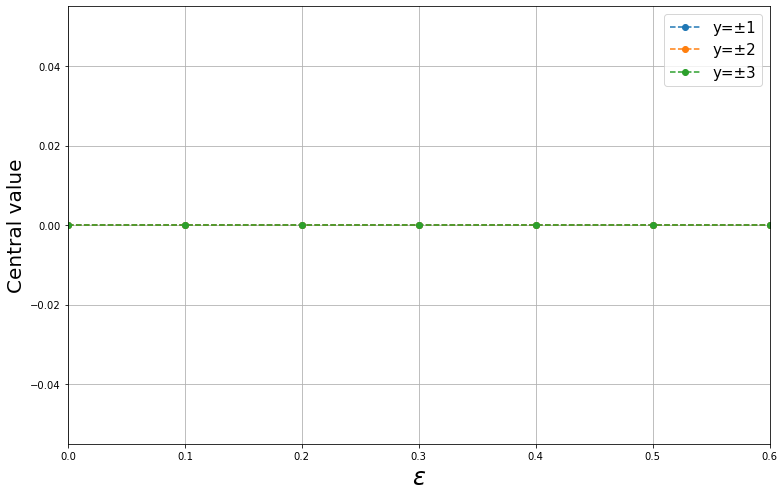

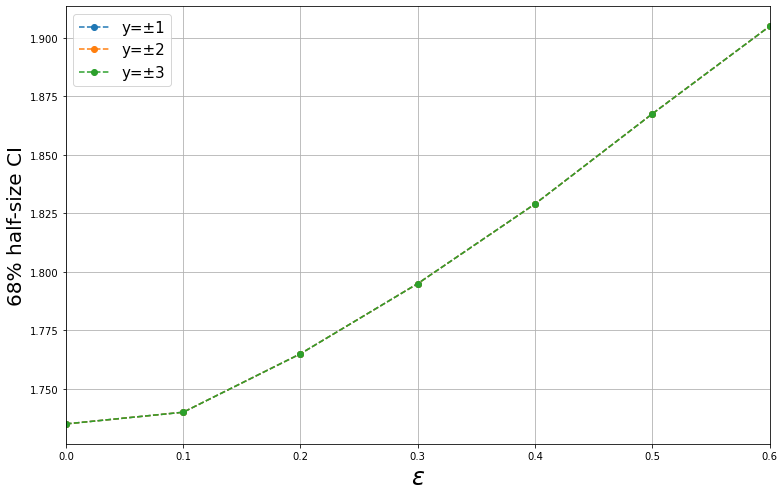

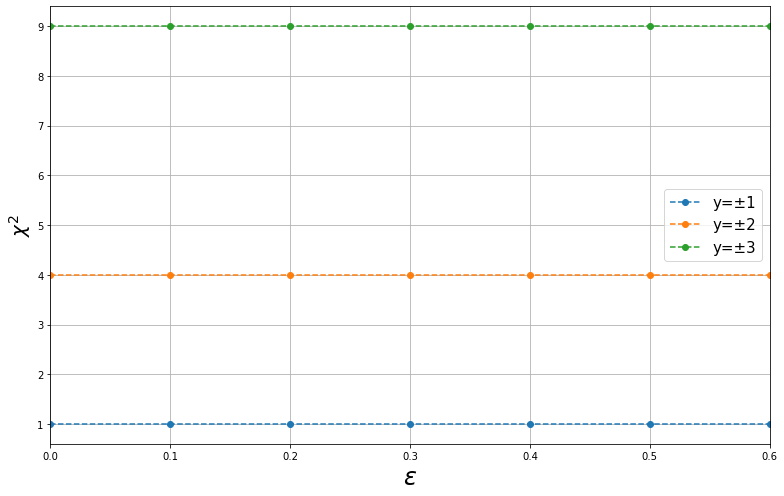

In [19]:
eps_grid = np.linspace(0., 0.6, 7)
y_vals = [1, 2, 3]
comb = GVMCombination('correlations/full_corr.yaml')
base_info = comb.input_data()
cv = {y: [] for y in y_vals}
ci = {y: [] for y in y_vals}
gof = {y: [] for y in y_vals}
for y in y_vals:
    for eps in eps_grid:
        info = deepcopy(base_info)
        info['data']['measurements']['m1']['central'] = float(y)
        info['data']['measurements']['m2']['central'] = -float(y)
        info['syst']['sys1']['epsilon'] = float(eps)
        comb.update_data(info)
        cv[y].append(comb.fit_results['mu'])
        ci[y].append(comb.confidence_interval()[2])
        gof[y].append(comb.goodness_of_fit())

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, cv[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel('Central value', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/full_cv.png')
plt.show()

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, ci[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel('68% half-size CI', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/full_ci.png')
plt.show()

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, gof[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel(r'$\chi^2$', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/full_gof.png')
plt.show()


### Hybrid correlation


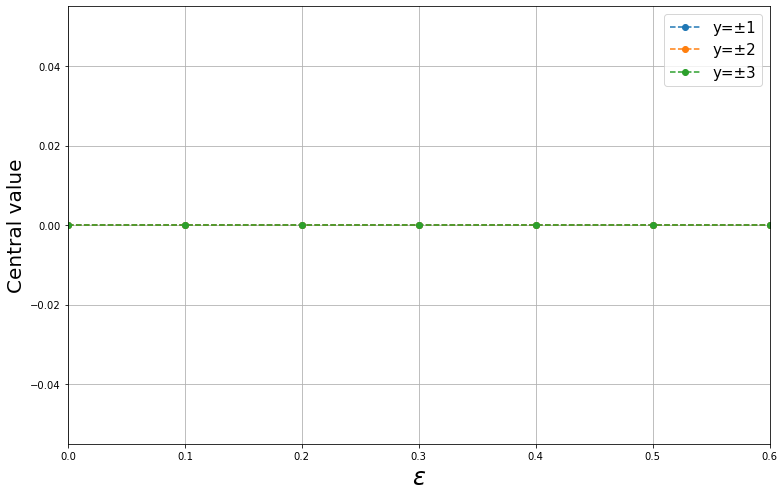

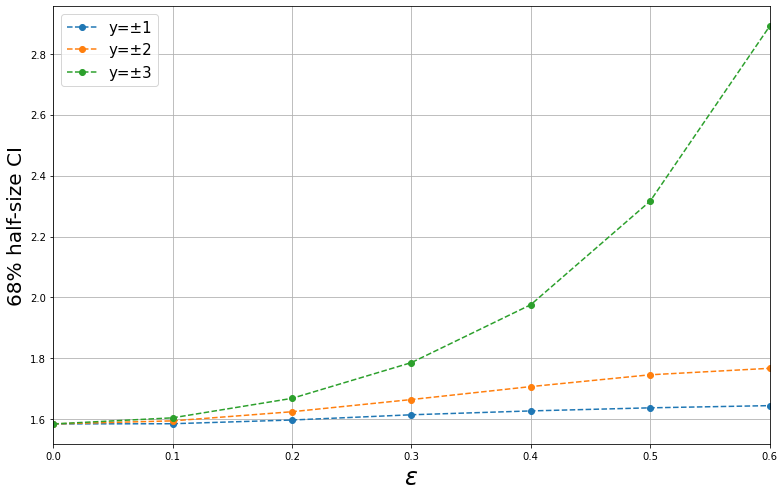

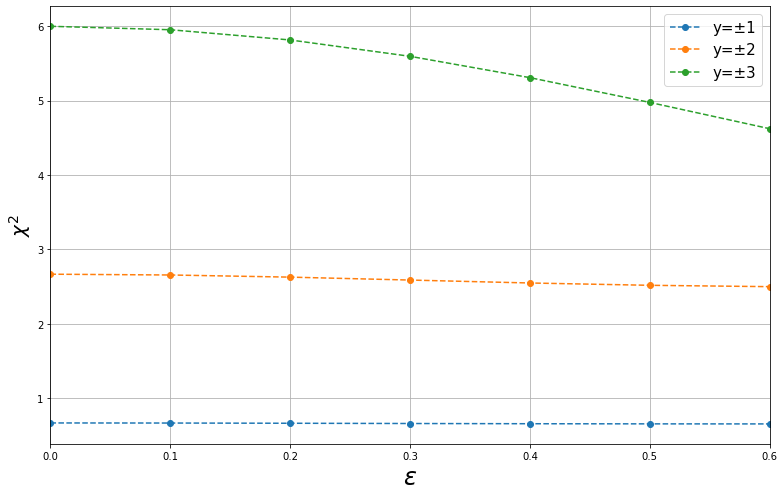

In [20]:
eps_grid = np.linspace(0., 0.6, 7)
y_vals = [1, 2, 3]
comb = GVMCombination('correlations/hybrid_corr.yaml')
base_info = comb.input_data()
cv = {y: [] for y in y_vals}
ci = {y: [] for y in y_vals}
gof = {y: [] for y in y_vals}
for y in y_vals:
    for eps in eps_grid:
        info = deepcopy(base_info)
        info['data']['measurements']['m1']['central'] = float(y)
        info['data']['measurements']['m2']['central'] = -float(y)
        info['syst']['sys1']['epsilon'] = float(eps)
        comb.update_data(info)
        cv[y].append(comb.fit_results['mu'])
        ci[y].append(comb.confidence_interval()[2])
        gof[y].append(comb.goodness_of_fit())

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, cv[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel('Central value', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/hybrid_cv.png')
plt.show()

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, ci[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel('68% half-size CI', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/hybrid_ci.png')
plt.show()

plt.figure(figsize=(11,7))
for y in y_vals:
    plt.plot(eps_grid, gof[y], '--o', label=f'y=±{y}')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel(r'$\chi^2$', fontsize=20)
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('output/hybrid_gof.png')
plt.show()
